<a href="https://colab.research.google.com/github/brianmanderson/Image_Prediction/blob/main/fit_fakeandphantom_twomodels.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



Licensed under the Apache License, Version 2.0 (the "License");

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

#EPIDEEP: Generating EPID images

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/generative/pix2pix"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/generative/pix2pix.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/pix2pix.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/generative/pix2pix.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This Google Colab Notebook heavily buroows from the pix2pix example. 
How to build and train a conditional generative adversarial network (cGAN) called pix2pix that learns a mapping from input images to output images, as described in [Image-to-image translation with conditional adversarial networks](https://arxiv.org/abs/1611.07004) by Isola et al. (2017). pix2pix is not application specific—it can be applied to a wide range of tasks, including synthesizing photos from label maps, generating colorized photos from black and white images, turning Google Maps photos into aerial images, and even transforming sketches into photos.

In the pix2pix cGAN, you condition on input images and generate corresponding output images. cGANs were first proposed in [Conditional Generative Adversarial Nets](https://arxiv.org/abs/1411.1784) (Mirza and Osindero, 2014)

The architecture of your network will contain:

- A generator with a [U-Net]([U-Net](https://arxiv.org/abs/1505.04597))-based architecture.
- A discriminator represented by a convolutional PatchGAN classifier (proposed in the [pix2pix paper](https://arxiv.org/abs/1611.07004)).

Note that each epoch can take around 15 seconds on a single V100 GPU.



## Import TensorFlow and other libraries

In [2]:
import tensorflow as tf

import os
import sys 
import pathlib
import time
import datetime
import numpy as np
from matplotlib import pyplot as plt
from IPython import display
import tensorflow.experimental.numpy as tnp
import pandas as pd
print(sys.version_info)

sys.version_info(major=3, minor=8, micro=10, releaselevel='final', serial=0)


In [3]:
running_local = False
try:
    from google.colab import drive
    drive.mount('/content/drive')
    nb_path = '/content/notebooks'
    os.symlink('/content/drive/MyDrive/Colab Notebooks', nb_path)
    sys.path.insert(0, nb_path)  # or append(nb_path)
except:
    running_local = True
    print("Running locally")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Running locally


Line to install pymedphys which has a gamma function. Libaray was saved to Google drive and is commented out.

In [4]:
#!pip install --target=$nb_path pymedphys

In [5]:
!pip install SimpleITK
!pip install pymedphys
!pip install PlotScrollNumpyArrays

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
#import SimpleITK as sitk
import pymedphys

In [7]:
!git clone --recurse-submodules -j8 https://github.com/brianmanderson/Data_Generators

fatal: destination path 'Data_Generators' already exists and is not an empty directory.


In [8]:
from Data_Generators.TFRecord_to_Dataset_Generator import DataGeneratorClass
from Data_Generators.Image_Processors_Module.src.Processors.TFDataSets import ConstantProcessors as CProcessors,\
    RelativeProcessors as RProcessors

In [9]:
class ImageProcessor(object):
    def parse(self, *args, **kwargs):
        return args, kwargs
def _check_keys_(input_features, keys):
    if type(keys) is list or type(keys) is tuple:
        for key in keys:
            assert key in input_features.keys(), 'Make sure the key you are referring to is present in the features, ' \
                                                 '{} was not found'.format(key)
    else:
        assert keys in input_features.keys(), 'Make sure the key you are referring to is present in the features, ' \
                                              '{} was not found'.format(keys)
class DivideBasedOnOther(ImageProcessor):
    def __init__(self, guiding_keys=('annotation',), changing_keys=('image',)):
        self.guiding_keys, self.changing_keys = guiding_keys, changing_keys

    def parse(self, input_features, *args, **kwargs):
        _check_keys_(input_features=input_features, keys=self.guiding_keys)
        _check_keys_(input_features=input_features, keys=self.changing_keys)
        for guiding_key, changing_key in zip(self.guiding_keys, self.changing_keys):
            input_features[changing_key] = input_features[changing_key] / input_features[guiding_key]
        return input_features

In [10]:
def return_generator(records_path, proj_to_panel=True, add_5cm_keys=False, global_norm=False, **kwargs):
  generator = DataGeneratorClass(record_paths=records_path, delete_old_cache=True)
  all_keys = ('pdos_array', 'fluence_array','drr_array', 'deep_to_panel_array', 'iso_to_panel_array', 'shallow_to_panel_array')
  drr_keys = ('drr_array', 'deep_to_panel_array', 'iso_to_panel_array', 'shallow_to_panel_array', )
  input_keys = ('pdos_array', 'drr_array', 'iso_to_panel_array')
  if add_5cm_keys:
    if proj_to_panel:
      input_keys = ('pdos_array', 'drr_array', 'deep_to_panel_array', 'iso_to_panel_array',
                    'shallow_to_panel_array')
    else:
      input_keys = ('pdos_array', 'drr_array', '5cm_deep_array', 'iso_array', 'shallow_array')
  print(f"Inputs are {input_keys}")
  base_processors = [
                     CProcessors.Squeeze(image_keys=all_keys),
                     CProcessors.ExpandDimension(axis=-1, image_keys=all_keys),
                     CProcessors.MultiplyImagesByConstant(keys=drr_keys,
                                                          values=(1/255, 1/255, 1/255, 1/255)),
                     ]
 
  if global_norm:
    print('Global norm')
    base_processors += [
                        CProcessors.MultiplyImagesByConstant(keys=('pdos_array',
                                                                'fluence_array'),
                                                             values=(1, 1)) #(1/2, 1/(.3876*2))
                        ]
  else:
    base_processors += [
                        RProcessors.NormalizeBasedOnOther(guiding_keys=('pdos_array', 'pdos_array'),
                                                          changing_keys=('fluence_array', 'pdos_array'),
                                                          reference_method=('reduce_max', 'reduce_max'),
                                                          changing_methods=('divide', 'divide'))
                        ]

    base_processors += [
    CProcessors.CreateNewKey(input_keys=('drr_array',), output_keys=('exp_new_drr_array',)),
    CProcessors.MultiplyImagesByConstant(keys=('exp_new_drr_array',), values=(-4.0,)),
    CProcessors.TakeExpOfKey(input_keys=('exp_new_drr_array',)),

    CProcessors.CreateNewKey(input_keys=('drr_array',), output_keys=('multiplied_drr_array',)),
    CProcessors.MultiplyImagesByConstant(keys=('multiplied_drr_array',), values=(0.15,)),
    CProcessors.AddImagesTogether(keys=('exp_new_drr_array', 'multiplied_drr_array'), out_key='exp_new_drr_array'),

    CProcessors.CreateNewKey(input_keys=('drr_array',), output_keys=('squared_drr_array',)),
    CProcessors.MultiplyImagesTogether(keys=('squared_drr_array', 'squared_drr_array'), out_key='squared_drr_array'),
    CProcessors.MultiplyImagesByConstant(keys=('squared_drr_array',), values=(-0.1,)),
    CProcessors.AddImagesTogether(keys=('exp_new_drr_array', 'squared_drr_array'), out_key='summed_drr_array'),

    CProcessors.MultiplyImagesTogether(keys=('pdos_array', 'summed_drr_array'), out_key='pdos_drr_multiplied'),
  
  ] 


  base_processors += [
                      CProcessors.CombineKeys(axis=-1,
                                              image_keys=input_keys,
                                              output_key='output'),
                      CProcessors.ReturnOutputs(input_keys=('output',),
                                                output_keys=('fluence_array',))
                                                #output_keys=('pdos_drr_multiplied',))
  ]
  base_processors += [
                      {'batch': 1}, {'repeat'}
                      ]
  generator.compile_data_set(image_processors=base_processors, debug=False)
  return generator

In [11]:
def return_generator(records_path, proj_to_panel=True, add_5cm_keys=False, global_norm=False, **kwargs):
  generator = DataGeneratorClass(record_paths=records_path, delete_old_cache=True)
  all_keys = ('pdos_array', 'fluence_array','drr_array', 'deep_to_panel_array', 'iso_to_panel_array', 'shallow_to_panel_array')
  drr_keys = ('drr_array', 'deep_to_panel_array', 'iso_to_panel_array', 'shallow_to_panel_array', )
  input_keys = ('pdos_array', 'drr_array', 'iso_to_panel_array')
  if add_5cm_keys:
    if proj_to_panel:
      input_keys = ('pdos_array', 'drr_array', 'deep_to_panel_array', 'iso_to_panel_array',
                    'shallow_to_panel_array')
    else:
      input_keys = ('pdos_array', 'drr_array', '5cm_deep_array', 'iso_array', 'shallow_array')
  print(f"Inputs are {input_keys}")
  base_processors = [
                     CProcessors.Squeeze(image_keys=all_keys),
                     CProcessors.ExpandDimension(axis=-1, image_keys=all_keys),
                     CProcessors.MultiplyImagesByConstant(keys=drr_keys,
                                                          values=(1/255, 1/255, 1/255, 1/255)),
                     ]
 
  if global_norm:
    print('Global norm')
    base_processors += [
                        CProcessors.MultiplyImagesByConstant(keys=('pdos_array',
                                                                'fluence_array'),
                                                             values=(1, 1)) #(1/2, 1/(.3876*2))
                        ]
  else:
    base_processors += [
                        RProcessors.NormalizeBasedOnOther(guiding_keys=('pdos_array', 'pdos_array'),
                                                          changing_keys=('fluence_array', 'pdos_array'),
                                                          reference_method=('reduce_max', 'reduce_max'),
                                                          changing_methods=('divide', 'divide'))
                        ]

    base_processors += [
    #CProcessors.CreateNewKey(input_keys=('drr_array',), output_keys=('exp_new_drr_array',)),
    #CProcessors.MultiplyImagesByConstant(keys=('exp_new_drr_array',), values=(-4.0,)),
    #CProcessors.TakeExpOfKey(input_keys=('exp_new_drr_array',)),

    CProcessors.CreateNewKey(input_keys=('drr_array',), output_keys=('mul_drr_array',)),
    CProcessors.MultiplyImagesByConstant(keys=('mul_drr_array',), values=(-2.970,)),
    #CProcessors.AddImagesTogether(keys=('new_drr_array', 'mul_drr_array'), out_key='new_drr_array'),

    CProcessors.CreateNewKey(input_keys=('drr_array',), output_keys=('squared_drr_array',)),
    CProcessors.MultiplyImagesTogether(keys=('squared_drr_array', 'squared_drr_array'), out_key='squared_drr_array'),
    CProcessors.MultiplyImagesByConstant(keys=('squared_drr_array',), values=(0.538066,)),
    CProcessors.AddImagesTogether(keys=('mul_drr_array', 'squared_drr_array'), out_key='summed_drr_array'),

    CProcessors.AddConstantToImages(keys=('summed_drr_array',),values=(-0.04349,)),

    CProcessors.TakeExpOfKey(input_keys=('summed_drr_array',)),   
    CProcessors.MultiplyImagesTogether(keys=('pdos_array', 'summed_drr_array'), out_key='summed_array'),
    CProcessors.MultiplyImagesByConstant(keys=('summed_array',), values=(-1.0,)),
    
    CProcessors.AddImagesTogether(keys=('fluence_array', 'summed_array'), out_key='scatter_array'),
  
  ] 


  base_processors += [
                      CProcessors.CombineKeys(axis=-1,
                                              image_keys=input_keys,
                                              output_key='output'),
                      CProcessors.ReturnOutputs(input_keys=('output',),
                                                #output_keys=('fluence_array',))
                                                output_keys=('scatter_array',))
                                                #output_keys=('summed_array',))
  ]
  base_processors += [
                      {'batch': 1}, {'repeat'}
                      ]
  generator.compile_data_set(image_processors=base_processors, debug=False)
  return generator

In [12]:
# The batch size of 1 produced better results for the U-Net in the original pix2pix experiment
BATCH_SIZE = 1
# Each image is 256x256 in size
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [13]:
def load_data_from_generator(generator):
  data = {'input' : [], 'rtimg' : []}
  iterator = iter(generator.data_set)
  for _ in range(len(generator)):
    x, y = next(iterator)
    data['input'].append(x[0][0])
    data['rtimg'].append(y[0][0])
  return data

# Return a train and validation dataset based on which fold you want to exclude

In [14]:
def return_datasets(data_generators):
  all_datasets = {}
  for i in data_generators.keys():
    generator = data_generators[i]
    all_datasets[i] = tf.data.Dataset.from_tensor_slices((load_data_from_generator(generator)))
  return all_datasets

def return_fold_datasets(data_generators, batch_size=1):
  all_datasets = return_datasets(data_generators)

  train_dataset = all_datasets['train']
  train_dataset = train_dataset.shuffle(len(train_dataset))
  train_dataset = train_dataset.batch(int(batch_size))
  
  valid_dataset = all_datasets['validation']
  valid_dataset = valid_dataset.shuffle(len(valid_dataset))
  valid_dataset = valid_dataset.batch(1)

  test_dataset = all_datasets['test']
  test_dataset = test_dataset.shuffle(len(test_dataset))
  test_dataset = test_dataset.batch(1)
  return train_dataset, valid_dataset, test_dataset

In [15]:
def return_dataset(generator, batch):
  input_values = []
  output_values = []
  iterator = iter(generator.data_set)
  for _ in range(len(generator)):
    x, y = next(iterator)
    input_values.append(x[0][0])
    output_values.append(y[0][0])
  input_dataset = tf.data.Dataset.from_tensor_slices(input_values)
  output_dataset = tf.data.Dataset.from_tensor_slices(output_values)
  dataset = tf.data.Dataset.zip((input_dataset, output_dataset))
  dataset = dataset.shuffle(len(dataset)).batch(int(batch))
  return dataset

In [35]:
def return_generators(base_path, excluded_fold=5, batch=1, **kwargs):
  data_generators = {}
  train_folder_names = []
  val_folder_names = []
  test_folder_names = []
  #train_folder_names.append(os.path.join(base_path, 'onefrac_train'))
  #val_folder_names.append(os.path.join(base_path, 'onefrac_valid'))
  train_folder_names.append(os.path.join(base_path, 'phantom_train'))
  val_folder_names.append(os.path.join(base_path, 'phantom_valid'))
  #test_folder_names.append(os.path.join(base_path, 'phantom_valid'))
  #test_folder_names.append(os.path.join(base_path, 'test_pelvis'))
  test_folder_names.append(os.path.join(base_path, 'solidwater/swall'))
  
  # for i in range(1,6):
  #   folder_name = '/content/drive/My Drive/data/fold{}'.format(i)
  #   if i != excluded_fold:
  #     train_folder_names.append(folder_name)
  #   else:
  #     val_folder_names.append(folder_name)
  
  train_gen = return_generator(train_folder_names, batch=1, **kwargs)
  train_gen = return_dataset(train_gen, batch)

  valid_gen = return_generator(val_folder_names, batch=1, **kwargs)
  valid_gen = return_dataset(valid_gen, 1)
  
  test_gen = return_generator(test_folder_names, batch=1, **kwargs)
  test_gen = return_dataset(test_gen, 1)
  
  
  return train_gen, valid_gen, test_gen

In [36]:
batch = 1
base_path = '/content/drive/My Drive/data'
train_dataset, valid_dataset, test_dataset = return_generators(base_path, excluded_fold=1, batch=batch)

Inputs are ('pdos_array', 'drr_array', 'iso_to_panel_array')
{'batch': 1}
{'repeat'}
Inputs are ('pdos_array', 'drr_array', 'iso_to_panel_array')
{'batch': 1}
{'repeat'}
Inputs are ('pdos_array', 'drr_array', 'iso_to_panel_array')
{'batch': 1}
{'repeat'}


In [18]:
iterx = iter(train_dataset.repeat())

206
83


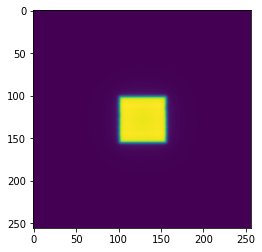

In [19]:
train_len = len(train_dataset)
valid_len = len(valid_dataset)
#test_len =  len(test_dataset)
x, y = next(iterx)
print(train_len)
print(valid_len)
#print(test_len)
plt.imshow(x[0,...,0])

In [20]:
stop

NameError: ignored

In [ ]:
#train_len = len(train_dataset)
#valid_len = len(valid_dataset)
#test_len =  len(test_dataset)

itery = iter(test_dataset.repeat())
x, y = next(itery)
#print(train_len)
#print(valid_len)
#print(test_len)
#plt.imshow(y[0,...,0])

rt = y[0,...,0].numpy()

pdos = x[0,...,0].numpy()
cbct = x[0,...,1].numpy()
#plt.plot(pdos[128,1:256],'b')
#plt.plot(cbct[128,1:256],'r')
plt.plot(rt[128,1:256],'k')
#plt.ylim([-0.05,0.1])
#plt.ylim([0.86,0.92])
#plt.ylim([0.58,0.6])
plt.show()

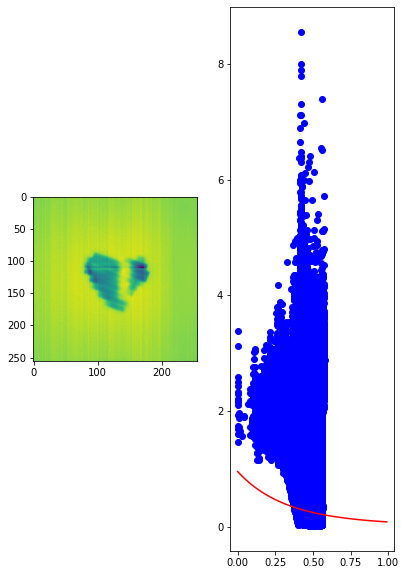

In [48]:
train_len = len(train_dataset)
valid_len = len(valid_dataset)
#test_len =  len(test_dataset)
x, y = next(iterx)
#print(train_len)
#print(valid_len)
#print(test_len)
#plt.imshow(y[0,...,0])

rt = y[0,...,0].numpy()

pdos = x[0,...,0].numpy()
cbct = x[0,...,1].numpy()

plt.figure(figsize=(10, 10))
plt.subplot(1,3,1)

plt.imshow(rt)
#plt.plot(pdos[128,1:256],'b')
#plt.plot(cbct[128,1:256],'r')

#plt.show()

cbctval = []
ratio = []
pdosval = [] 

rtmax = rt.max(0).max(-1)
#print(rtmax)

for i in range(0,256):
  for j in range(0,256):
    if(rt[i,j] > rtmax*0.5):
      cbctval = np.append(cbctval,cbct[i,j])
      pdosval = np.append(pdosval,pdos[i,j])
      ratio = np.append(ratio,rt[i,j]/pdos[i,j])

plt.subplot(1,3,2)
plt.plot(cbctval,ratio,'bo')

#xp = np.arange(0, 200.0, 0.1)
#yp = np.exp(-4.0/255 * xp) + 0.15/255 * xp - 0.1/65025 * xp * xp
# #yp = pdosval*( np.exp(-4.0/255 *cbctval) + 0.15/255 * cbctval - 0.1/65025 * cbctval * cbctval)
xp = np.arange(0, 1.0, 0.01)
#yp = np.exp(-4.0 * xp) + 0.15 * xp -0.1* xp * xp
#yp = np.exp(-4.0 * xp) 
yp = np.exp(0.538066*xp*xp-2.970*xp-0.04349)

plt.plot(xp, yp,'r')

#plt.subplot(1,3,3)
#plt.plot(rt[128,1:256]/pdos[128,1:256],'b')
#plt.plot(pdos[128,1:256],'r')
#plt.plot(rt[128,1:256],'b')

You can inspect some of the preprocessed output:

In [ ]:
x, y = next(iterx)

idx = 1 
pdos = x[0,...,idx].numpy()

#x = tf.squeeze(x,0)
ks = 64 
ave = tf.keras.layers.AveragePooling2D(pool_size=(ks,ks), strides=(1,1),padding='same')(x)
#tf.keras.layers.Conv2D(filters=1, kernel_size=(4,4), strides=(1,1),dilation_rate=(4,4), padding='same')(x)
#ave = tf.keras.layers.AveragePooling2D(pool_size=(64,64), strides=(1,1),padding='same')(x)
#ave3 = tf.keras.layers.AveragePooling2D(pool_size=(64,64), strides=(1,1),padding='same')(ave)
#ave2 = tf.keras.layers.AveragePooling2D(pool_size=(64,64), strides=(1,1),padding='same')(ave3)
#ave = tf.keras.layers.AveragePooling2D(pool_size=(8,8), strides=(1,1),padding='same')(ave)


val = ave[0,...,idx].numpy()
plt.subplot(211)
print(val.shape)
#val2 = ave2[0,...,1].numpy()
plt.plot(pdos[128,1:256],'r')

#plt.plot(val2[128,1:256],'g')
plt.subplot(212)
#maxpix = int(256/ks)
#mid = int(maxpix/2)
#plt.plot(val[mid,1:maxpix],'b')
plt.plot(val[128,1:256],'b')


In [49]:
def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

Define the upsampler (decoder):

In [50]:
def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

In [51]:
OUTPUT_CHANNELS = 1

In [52]:
def GeneratorP():
  inputs = tf.keras.layers.Input(shape=[256, 256, 3])
  #inputsPDOS = tf.expand_dims(tinputs[..., 0], axis=-1)
  #inputsCT = tf.expand_dims(tinputs[..., 1], axis=-1)
  #halfCBCT = tf.expand_dims(tinputs[..., 2], axis=-1)

  #inputs1 = tf.keras.layers.Concatenate()([inputsPDOS,inputsCT])
  #inputs = tf.keras.layers.Concatenate()([patten,inputs1])

  down_stack = [
    downsample(64, 4, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
    downsample(128, 4),  # (batch_size, 64, 64, 128)
    downsample(256, 4),  # (batch_size, 32, 32, 256)
    downsample(512, 4),  # (batch_size, 16, 16, 512)
    downsample(512, 4),  # (batch_size, 8, 8, 512)
    downsample(512, 4),  # (batch_size, 4, 4, 512)
    downsample(512, 4),  # (batch_size, 2, 2, 512)
    downsample(512, 4),  # (batch_size, 1, 1, 512)
  ]

  up_stack = [
    upsample(512, 4, apply_dropout=True),  # (batch_size, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 8, 8, 1024)
    upsample(512, 4),  # (batch_size, 16, 16, 1024)
    upsample(256, 4),  # (batch_size, 32, 32, 512)
    upsample(128, 4),  # (batch_size, 64, 64, 256)
    upsample(64, 4),  # (batch_size, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh')  # (batch_size, 256, 256, 3)

  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  #return x
  return tf.keras.Model(inputs=inputs, outputs=x)

In [ ]:
def GeneratorLK():

  kernel = 64
  inputs = tf.keras.layers.Input(shape=[256, 256, 3])
  
  inputsPDOS = tf.expand_dims(inputs[..., 0], axis=-1)
  inputsCT = tf.expand_dims(inputs[..., 1], axis=-1)
  halfCBCT = tf.expand_dims(inputs[..., 2], axis=-1)

  pdos_layer1 = tf.keras.layers.Conv2D(1, 1, strides=1, activation=None, padding='same', trainable = True,
                                      kernel_initializer=tf.random_normal_initializer(1.0, 0.01), use_bias=True)(inputsPDOS)
 
  pdos_layer2 = tf.keras.layers.Conv2D(1, 1, strides=1, activation=None, padding='same', 
                                      kernel_initializer=tf.random_normal_initializer(0.05, 0.01), use_bias=True)(inputsPDOS)

  pdos_layer3 = tf.keras.layers.Conv2D(1, 1, strides=1, activation=None, padding='same', trainable = True,
                                      kernel_initializer=tf.random_normal_initializer(1.0, 0.01), use_bias=True)(inputsPDOS)

  pdos_layer4 = tf.keras.layers.Conv2D(1, kernel, strides=1, activation=None, padding='same', trainable = True,
                                     kernel_initializer=tf.random_normal_initializer(0.0, 0.001), use_bias=True)(inputsPDOS)

  ct_layer1 = tf.keras.layers.Conv2D(1, 1, strides=1, activation=None, padding='same', trainable =True,
                                    kernel_initializer=tf.random_normal_initializer(4.0, 0.01), use_bias=True)(inputsCT)

  ct_layer2 = tf.keras.layers.Conv2D(1, 1, strides=1, activation=None, padding='same', 
                                    kernel_initializer=tf.random_normal_initializer(1.0, 0.01), use_bias=True)(inputsCT)

  ct_scatter = tf.keras.layers.Conv2D(1, kernel, padding='same', kernel_initializer=tf.random_normal_initializer(0.0, 0.001),
                                      activation=None)(inputsCT)

  exp1 = tf.math.exp(-ct_layer1)

  exp2 = tf.math.exp(-ct_layer2)

  pdos_exp1 = tf.keras.layers.Multiply()([pdos_layer1,exp1])

  pdos_exp2 = tf.keras.layers.Multiply()([pdos_layer2,exp2])

  sum1 = tf.keras.layers.Add()([pdos_exp1, pdos_exp2])

  sum2 = tf.keras.layers.Add()([pdos_layer3, sum1])

  scatter = tf.keras.layers.Multiply()([ct_scatter, pdos_layer4])
  last = tf.keras.layers.Add()([sum2, scatter])


  return tf.keras.Model(inputs=inputs, outputs=last)


In [ ]:
def GeneratorE():

  inputs = tf.keras.layers.Input(shape=[256, 256, 3])
  
  inputsPDOS = tf.expand_dims(inputs[..., 0], axis=-1)
  inputsCT = tf.expand_dims(inputs[..., 1], axis=-1)
  halfCBCT = tf.expand_dims(inputs[..., 2], axis=-1)

  pdos_layer1 = tf.keras.layers.Conv2D(1, 1, strides=1, activation=None, padding='same', trainable = True,
                                      kernel_initializer=tf.random_normal_initializer(1.0, 0.01), use_bias=True)(inputsPDOS)
 
  pdos_layer2 = tf.keras.layers.Conv2D(1, 1, strides=1, activation=None, padding='same', 
                                      kernel_initializer=tf.random_normal_initializer(0.05, 0.01), use_bias=True)(inputsPDOS)

  pdos_layer3 = tf.keras.layers.Conv2D(1, 1, strides=1, activation=None, padding='same', trainable = True,
                                      kernel_initializer=tf.random_normal_initializer(1.0, 0.01), use_bias=True)(inputsPDOS)

  # pdos_layer4 = tf.keras.layers.Conv2D(1, 1, strides=1, activation=None, padding='same', trainable = True,
  #                                      kernel_initializer=tf.random_normal_initializer(1.0, 0.01), use_bias=True)(inputsPDOS)

  ct_layer1 = tf.keras.layers.Conv2D(1, 1, strides=1, activation=None, padding='same', trainable =True,
                                    kernel_initializer=tf.random_normal_initializer(4.0, 0.01), use_bias=True)(inputsCT)

  ct_layer2 = tf.keras.layers.Conv2D(1, 1, strides=1, activation=None, padding='same', 
                                    kernel_initializer=tf.random_normal_initializer(1.0, 0.01), use_bias=True)(inputsCT)

  exp1 = tf.math.exp(-ct_layer1)

  exp2 = tf.math.exp(-ct_layer2)

  pdos_exp1 = tf.keras.layers.Multiply()([pdos_layer1,exp1])

  pdos_exp2 = tf.keras.layers.Multiply()([pdos_layer1,exp2])

  sum1 = tf.keras.layers.Add()([pdos_exp1, pdos_exp2])

  sum2 = tf.keras.layers.Add()([pdos_layer2, sum1])

  pdosave = tf.keras.layers.GlobalAveragePooling2D()(pdos_layer3) 

  last = tf.keras.layers.Add()([pdosave, sum2])

  return tf.keras.Model(inputs=inputs, outputs=last)

In [ ]:
#print(generator.trainable_variables)

In [ ]:
# for layer in generator.layers:
#     print(layer.name, layer)
#     print(layer.weights)

In [ ]:
def GeneratorFixed():

  inputs = tf.keras.layers.Input(shape=[256, 256, 3])
  
  inputsPDOS = tf.expand_dims(inputs[..., 0], axis=-1)
  inputsCT = tf.expand_dims(inputs[..., 1], axis=-1)
  halfCBCT = tf.expand_dims(inputs[..., 2], axis=-1)

 
 
  ct_layer1 = tf.keras.layers.Conv2D(1, 1, strides=1, activation=None, padding='same', trainable =False,
                                   kernel_initializer=tf.keras.initializers.Constant(4.9641533), 
                                      use_bias=True,bias_initializer=tf.keras.initializers.Constant(0.05148066))(inputsCT)

  ct_layer2 = tf.keras.layers.Conv2D(1, 1, strides=1, activation=None, padding='same', trainable =False,
                                   kernel_initializer=tf.keras.initializers.Constant(1.0908785), 
                                      use_bias=True,bias_initializer=tf.keras.initializers.Constant(0.42798245))(inputsCT)

  pdos_layer1 = tf.keras.layers.Conv2D(1, 1, strides=1, activation=None, padding='same', trainable = False,
                                      kernel_initializer=tf.keras.initializers.Constant(0.6828056), 
                                      use_bias=True,bias_initializer=tf.keras.initializers.Constant(-0.00088083))(inputsPDOS)

  pdos_layer3 = tf.keras.layers.Conv2D(1, 1, strides=1, activation=None, padding='same', trainable = False,
                                      kernel_initializer=tf.keras.initializers.Constant(0.06649256), 
                                      use_bias=True,bias_initializer=tf.keras.initializers.Constant(0.00109639))(inputsPDOS)

  pdos_layer2 = tf.keras.layers.Conv2D(1, 1, strides=1, activation=None, padding='same', trainable = False,
                                      kernel_initializer=tf.keras.initializers.Constant(-0.07846075), 
                                      use_bias=True,bias_initializer=tf.keras.initializers.Constant(0.00109639))(inputsPDOS)




  exp1 = tf.math.exp(-ct_layer1)

  exp2 = tf.math.exp(-ct_layer2)

  pdos_exp1 = tf.keras.layers.Multiply()([pdos_layer1,exp1])

  pdos_exp2 = tf.keras.layers.Multiply()([pdos_layer1,exp2])

  sum1 = tf.keras.layers.Add()([pdos_exp1, pdos_exp2])

  sum2 = tf.keras.layers.Add()([pdos_layer2, sum1])

  pdosave = tf.keras.layers.GlobalAveragePooling2D()(pdos_layer3) 

  last = tf.keras.layers.Add()([pdosave, sum2])

  return tf.keras.Model(inputs=inputs, outputs=last)

In [38]:
def GeneratorFixed2():

  inputs = tf.keras.layers.Input(shape=[256, 256, 3])
  
  inputsPDOS = tf.expand_dims(inputs[..., 0], axis=-1)
  inputsCT = tf.expand_dims(inputs[..., 1], axis=-1)
  halfCBCT = tf.expand_dims(inputs[..., 2], axis=-1)


 
  ct_layer1 = tf.keras.layers.Conv2D(1, 1, strides=1, activation=None, padding='same', trainable =False,
                                   kernel_initializer=tf.keras.initializers.Constant(0.538066), 
                                      use_bias=False)(inputsCT)

  ct_layer2 = tf.keras.layers.Conv2D(1, 1, strides=1, activation=None, padding='same', trainable =False,
                                   kernel_initializer=tf.keras.initializers.Constant(-2.970), 
                                      use_bias=False)(inputsCT)

  pdos_layer1 = tf.keras.layers.Conv2D(1, 1, strides=1, activation=None, padding='same', trainable = False,
                                      kernel_initializer=tf.keras.initializers.Constant(1.0), 
                                      use_bias=False)(inputsPDOS)


  ct_square = tf.keras.layers.Multiply()([ct_layer1,ct_layer1])

  sum1 = tf.keras.layers.Add()([ct_square, ct_layer2])


  sum2 = tf.keras.layers.Lambda(lambda x:x+tf.constant(-0.04349))(sum1)
  #sum2 = tf.keras.layers.Add()([sum1,constant])


  exp1 = tf.math.exp(sum2)

  last = tf.keras.layers.Multiply()([pdos_layer1,exp1])

  return tf.keras.Model(inputs=inputs, outputs=last)


In [ ]:
from tensorflow.python.ops.array_ops import zeros
def GeneratorS(include_scatter=True, kernel=16, half_kernel=8, dilation_rate=1, add_half=False):
 

  inputs = tf.keras.layers.Input(shape=[256, 256, 3])
  
  inputsPDOS = tf.expand_dims(inputs[..., 0], axis=-1)
  inputsCT = tf.expand_dims(inputs[..., 1], axis=-1)
  halfCBCT = tf.expand_dims(inputs[..., 2], axis=-1)

  pdos_layer1 = tf.keras.layers.Conv2D(1, 1, strides=1, activation=None, padding='same', trainable = True,
                                      kernel_initializer=tf.random_normal_initializer(1.0, 0.01), use_bias=True)(inputsPDOS)
 
  pdos_layer2 = tf.keras.layers.Conv2D(1, 1, strides=1, activation=None, padding='same', 
                                      kernel_initializer=tf.random_normal_initializer(0.05, 0.01), use_bias=True)(inputsPDOS)

  pdos_layer3 = tf.keras.layers.Conv2D(1, 1, strides=1, activation=None, padding='same', trainable = True,
                                      kernel_initializer=tf.random_normal_initializer(1.0, 0.01), use_bias=True)(inputsPDOS)

  pdos_scatter = tf.keras.layers.Conv2D(1, kernel, strides=1, activation=None, padding='same', trainable = True,
                                        kernel_initializer=tf.random_normal_initializer(0.0, 0.01), use_bias=True)(inputsPDOS)

  ct_layer1 = tf.keras.layers.Conv2D(1, 1, strides=1, activation=None, padding='same', trainable =True,
                                    kernel_initializer=tf.random_normal_initializer(4.0, 0.01), use_bias=True)(inputsCT)

  ct_layer2 = tf.keras.layers.Conv2D(1, 1, strides=1, activation=None, padding='same', 
                                    kernel_initializer=tf.random_normal_initializer(1.0, 0.01), use_bias=True)(inputsCT)

  exp1 = tf.math.exp(-ct_layer1)

  exp2 = tf.math.exp(-ct_layer2)

  pdos_exp1 = tf.keras.layers.Multiply()([pdos_layer1,exp1])

  pdos_exp2 = tf.keras.layers.Multiply()([pdos_layer1,exp2])

  sum1 = tf.keras.layers.Add()([pdos_exp1, pdos_exp2])

  sum2 = tf.keras.layers.Add()([pdos_layer2, sum1])

  pdosave = tf.keras.layers.GlobalAveragePooling2D()(pdos_layer3) 

  last = tf.keras.layers.Add()([sum2,pdosave])


  ct_scatter = tf.keras.layers.Conv2D(1, kernel, dilation_rate=dilation_rate,
                                      padding='same', kernel_initializer=tf.random_normal_initializer(.01, 0.001),
                                      activation=None)(inputsCT)
  scatter = tf.keras.layers.Multiply()([ct_scatter, pdos_scatter])
  
  last = tf.keras.layers.Add()([last, scatter])
  
      
  return tf.keras.Model(inputs=inputs, outputs=last)

In [ ]:
from tensorflow.python.ops.array_ops import zeros
def GeneratorS2(kernel=32,dilation_rate=1):
 
  inputs = tf.keras.layers.Input(shape=[256, 256, 3])
  
  inputsPDOS = tf.expand_dims(inputs[..., 0], axis=-1)
  inputsCT = tf.expand_dims(inputs[..., 1], axis=-1)
  halfCBCT = tf.expand_dims(inputs[..., 2], axis=-1)

  inputsPCT = tf.keras.layers.Concatenate()([inputsPDOS,inputsCT])

  ct_layer1 = tf.keras.layers.Conv2D(32, kernel_size=(1,1), strides=1, activation="relu", padding='same', trainable = True,
                                      kernel_initializer=tf.random_normal_initializer(0.0, 0.01), use_bias=True)(inputsCT)

  ct_layer2 = tf.keras.layers.Conv2D(64, kernel_size=(1,1), strides=1, activation="relu", padding='same', trainable = True,
                                      kernel_initializer=tf.random_normal_initializer(0.0, 0.01), use_bias=True)(ct_layer1)

  up1 = tf.keras.layers.Conv2DTranspose(32, kernel_size=(1,1), strides=1, activation="relu", padding='same', trainable = True,
                                      kernel_initializer=tf.random_normal_initializer(0.0, 0.01), use_bias=True)(ct_layer2)
 
  upcbct = tf.keras.layers.Conv2DTranspose(1, kernel_size=(1,1), strides=1, activation="relu", padding='same', trainable = True,
                                      kernel_initializer=tf.random_normal_initializer(0.0, 0.01), use_bias=True)(up1) 

  pdos_scatter = tf.keras.layers.Conv2D(1, kernel, strides=1, activation=None, padding='same', trainable = True,
                                        kernel_initializer=tf.random_normal_initializer(0.0, 0.01), use_bias=True)(inputsPDOS)

  # ct_layer1 = tf.keras.layers.Conv2D(1, 1, strides=1, activation=None, padding='same', trainable =True,
  #                                   kernel_initializer=tf.random_normal_initializer(4.0, 0.01), use_bias=True)(inputsCT)

  # ct_layer2 = tf.keras.layers.Conv2D(1, 1, strides=1, activation=None, padding='same', 
  #                                   kernel_initializer=tf.random_normal_initializer(1.0, 0.01), use_bias=True)(inputsCT)


  ct_scatter = tf.keras.layers.Conv2D(1, kernel, dilation_rate=dilation_rate, padding='same', kernel_initializer=tf.random_normal_initializer(.01, 0.001),
                                      activation=None, use_bias=True)(upcbct)

  scatter = tf.keras.layers.Multiply()([ct_scatter, pdos_scatter])
  
      
  return tf.keras.Model(inputs=inputs, outputs=scatter)

In [ ]:
def GeneratorDCNN():

  inputs = tf.keras.layers.Input(shape=[256, 256, 3])
  
  inputsPDOS = tf.expand_dims(inputs[..., 0], axis=-1)
  inputsCT = tf.expand_dims(inputs[..., 1], axis=-1)
  halfCBCT = tf.expand_dims(inputs[..., 2], axis=-1)



  pdos_layer1 = tf.keras.layers.Conv2D(1, kernel_size=(1,1), strides=1, activation="relu", padding='same', trainable = True,
                                      kernel_initializer=tf.keras.initializers.Constant(1.0) , use_bias=True)(inputsPDOS)

  
  ct_layer1 = tf.keras.layers.Conv2D(32, kernel_size=(1,1), strides=1, activation="relu", padding='same', trainable = True,
                                      kernel_initializer=tf.random_normal_initializer(0.0, 0.01), use_bias=True)(inputsCT)

  ct_layer2 = tf.keras.layers.Conv2D(64, kernel_size=(1,1), strides=1, activation="relu", padding='same', trainable = True,
                                      kernel_initializer=tf.random_normal_initializer(0.0, 0.01), use_bias=True)(ct_layer1)

  up1 = tf.keras.layers.Conv2DTranspose(32, kernel_size=(1,1), strides=1, activation="relu", padding='same', trainable = True,
                                      kernel_initializer=tf.random_normal_initializer(0.0, 0.01), use_bias=True)(ct_layer2)
 
  up2 = tf.keras.layers.Conv2DTranspose(1, kernel_size=(1,1), strides=1, activation="relu", padding='same', trainable = True,
                                      kernel_initializer=tf.random_normal_initializer(0.0, 0.01), use_bias=True)(up1) 
 
  catlayer = tf.keras.layers.Multiply()([pdos_layer1,up2])

 

  return tf.keras.Model(inputs=inputs, outputs=catlayer)


In [ ]:
def GeneratorDCNN2():

  inputs = tf.keras.layers.Input(shape=[256, 256, 3])
  
  inputsPDOS = tf.expand_dims(inputs[..., 0], axis=-1)
  inputsCT = tf.expand_dims(inputs[..., 1], axis=-1)
  halfCBCT = tf.expand_dims(inputs[..., 2], axis=-1)



  pdos_layer1 = tf.keras.layers.Conv2D(32, kernel_size=(3,3), strides=1, activation="relu", padding='same', trainable = True,
                                      kernel_initializer=tf.random_normal_initializer(1.0, 0.01), use_bias=True)(inputsPDOS)

  pdos_layer2 = tf.keras.layers.Conv2D(64, kernel_size=(3,3), strides=1, activation="relu", padding='same', trainable = True,
                                      kernel_initializer=tf.random_normal_initializer(0.0, 0.01), use_bias=True)(pdos_layer1)

  pdos_layer3 = tf.keras.layers.Conv2D(128, kernel_size=(3,3), strides=1, activation="relu", padding='same', trainable = True,
                                      kernel_initializer=tf.random_normal_initializer(0.0, 0.01), use_bias=True)(pdos_layer2)

  ct_layer1 = tf.keras.layers.Conv2D(32, kernel_size=(3,3), strides=1, activation="relu", padding='same', trainable = True,
                                      kernel_initializer=tf.random_normal_initializer(0.0, 0.01), use_bias=True)(inputsCT)

  ct_layer2 = tf.keras.layers.Conv2D(64, kernel_size=(3,3), strides=1, activation="relu", padding='same', trainable = True,
                                      kernel_initializer=tf.random_normal_initializer(0.0, 0.01), use_bias=True)(ct_layer1)

  ct_layer3 = tf.keras.layers.Conv2D(128, kernel_size=(3,3), strides=1, activation="relu", padding='same', trainable = True,
                                      kernel_initializer=tf.random_normal_initializer(0.0, 0.01), use_bias=True)(ct_layer2)


  catlayer = tf.keras.layers.concatenate([pdos_layer3,ct_layer3],axis=-1)

  up1 = tf.keras.layers.Conv2DTranspose(128, kernel_size=(3,3), strides=1, activation="relu", padding='same', trainable = True,
                                      kernel_initializer=tf.random_normal_initializer(0.0, 0.01), use_bias=True)(catlayer)
        
  up2 = tf.keras.layers.Conv2DTranspose(64, kernel_size=(3,3), strides=1, activation="relu", padding='same', trainable = True,
                                      kernel_initializer=tf.random_normal_initializer(0.0, 0.01), use_bias=True)(up1)                                   

  up3 = tf.keras.layers.Conv2DTranspose(32, kernel_size=(3,3), strides=1, activation="relu", padding='same', trainable = True,
                                      kernel_initializer=tf.random_normal_initializer(0.0, 0.01), use_bias=True)(up2)   

  last = tf.keras.layers.Conv2DTranspose(1, kernel_size=(3,3), strides=1, activation="relu", padding='same', trainable = True,
                                      kernel_initializer=tf.random_normal_initializer(0.0, 0.01), use_bias=True)(up3) 


  return tf.keras.Model(inputs=inputs, outputs=last)



Define the generator with the downsampler and the upsampler:

In [89]:
def GeneratorDSE():

  inputs = tf.keras.layers.Input(shape=[256, 256, 3])
  
  inputsPDOS = tf.expand_dims(inputs[..., 0], axis=-1)
  inputsCT = tf.expand_dims(inputs[..., 1], axis=-1)
  halfCBCT = tf.expand_dims(inputs[..., 2], axis=-1)

  initializer = tf.random_normal_initializer(0., 0.02)

  inputt = tf.keras.layers.Concatenate()([inputsPDOS,inputsCT])

  #Downsample PDOS with average pooling
  ave1  = tf.keras.layers.AveragePooling2D(pool_size=(2,2), strides=2, padding='same') (inputsPDOS)  #downsampled to 128 
  ave2  = tf.keras.layers.AveragePooling2D(pool_size=(2,2), strides=2, padding='same') (ave1) #downsampled to 64
  ave3  = tf.keras.layers.AveragePooling2D(pool_size=(2,2), strides=2, padding='same') (ave2) #downsampled to 32
  ave4  = tf.keras.layers.AveragePooling2D(pool_size=(2,2), strides=2, padding='same') (ave3) #downsampled to 16
  ave5  = tf.keras.layers.AveragePooling2D(pool_size=(2,2), strides=2, padding='same') (ave4) #downsampled to 8
  ave6  = tf.keras.layers.AveragePooling2D(pool_size=(2,2), strides=2, padding='same') (ave5) #downsampled to 4
  
  #apply a 3x3 kernal to average pooled PDOS
  cave1 = tf.keras.layers.Conv2D(5, 2, strides=1, padding='same',kernel_initializer=initializer, use_bias=False,activation='relu') (ave1)
  cave2 = tf.keras.layers.Conv2D(10, 2, strides=1, padding='same',kernel_initializer=initializer, use_bias=False,activation='relu') (ave2)
  cave3 = tf.keras.layers.Conv2D(20, 2, strides=1, padding='same',kernel_initializer=initializer, use_bias=False,activation='relu') (ave3)
  cave4 = tf.keras.layers.Conv2D(30, 2, strides=1, padding='same',kernel_initializer=initializer, use_bias=False,activation='relu') (ave4)
  cave5 = tf.keras.layers.Conv2D(40, 2, strides=1, padding='same',kernel_initializer=initializer, use_bias=False,activation='relu') (ave5)
  cave6 = tf.keras.layers.Conv2D(50, 2, strides=1, padding='same',kernel_initializer=initializer, use_bias=False,activation='relu') (ave6)

  # Down sample and get feature maps for 3 channgles.
  # Cat the average pooled input with UNET of the CT layer
  first = tf.keras.layers.Conv2D(9, 2, strides=1, padding='same',kernel_initializer=initializer, use_bias=False,activation='relu') (inputsCT)
  
  down1 = tf.keras.layers.Conv2D(15, 2, strides=2, padding='same',kernel_initializer=initializer, use_bias=False,activation='relu') (first)
  cat1 = tf.keras.layers.Concatenate()([cave1,down1])
  
  down2 = tf.keras.layers.Conv2D(31, 2, strides=2, padding='same',kernel_initializer=initializer, use_bias=False,activation='relu') (cat1)
  cat2 = tf.keras.layers.Concatenate()([cave2,down2])
  
  down3 = tf.keras.layers.Conv2D(63, 2, strides=2, padding='same',kernel_initializer=initializer, use_bias=False,activation='relu') (cat2)
  cat3 = tf.keras.layers.Concatenate()([cave3,down3])

  down4 = tf.keras.layers.Conv2D(127, 2, strides=2, padding='same',kernel_initializer=initializer, use_bias=False,activation='relu') (cat3)
  cat4 = tf.keras.layers.Concatenate()([cave4,down4])

  down5 = tf.keras.layers.Conv2D(127, 2, strides=2, padding='same',kernel_initializer=initializer, use_bias=False,activation='relu') (cat4)
  cat5 = tf.keras.layers.Concatenate()([cave5,down5])

  down6 = tf.keras.layers.Conv2D(127, 2, strides=2, padding='same',kernel_initializer=initializer, use_bias=False,activation='relu') (cat5)
  cat6 = tf.keras.layers.Concatenate()([cave6,down6])

  # Middle bottleneck layer
  #mid = tf.keras.layers.Conv2DTranspose(128, 2, strides=2, padding='same',kernel_initializer=initializer, use_bias=False,activation='relu')(cat6)
 
  mid = tf.keras.layers.UpSampling2D(size=(2,2), interpolation='bilinear')(cat6)
  mid = tf.keras.layers.Conv2DTranspose(128, 2, strides=1, padding='same',kernel_initializer=initializer, use_bias=False,activation='relu')(mid)
  
  upcat5 = tf.keras.layers.Concatenate()([cat5,mid])
  up5 = tf.keras.layers.Conv2DTranspose(128, 2, strides=2, padding='same',kernel_initializer=initializer, use_bias=False,activation='relu')(upcat5)

  #up5 = tf.keras.layers.UpSampling2D(size=(2,2), interpolation='bilinear')(upcat5)
  #up5 = tf.keras.layers.Conv2DTranspose(128, 2, strides=1, padding='same',kernel_initializer=initializer, use_bias=False,activation='relu')(up5)

  upcat4 = tf.keras.layers.Concatenate()([cat4,up5])
  up4 = tf.keras.layers.Conv2DTranspose(64, 2, strides=2, padding='same',kernel_initializer=initializer, use_bias=False,activation='relu')(upcat4)

  #up4 = tf.keras.layers.UpSampling2D(size=(2,2), interpolation='bilinear')(upcat4)
  #up4 = tf.keras.layers.Conv2DTranspose(64, 2, strides=1, padding='same',kernel_initializer=initializer, use_bias=False,activation='relu')(up4)


  upcat3 = tf.keras.layers.Concatenate()([cat3,up4])
  up3 = tf.keras.layers.Conv2DTranspose(32, 2, strides=2, padding='same',kernel_initializer=initializer, use_bias=False,activation='relu')(upcat3)

  #up3 = tf.keras.layers.UpSampling2D(size=(2,2), interpolation='bilinear')(upcat3)
  #up3 = tf.keras.layers.Conv2DTranspose(32, 2, strides=1, padding='same',kernel_initializer=initializer, use_bias=False,activation='relu')(up3)

  upcat2 = tf.keras.layers.Concatenate()([cat2,up3])
  up2 = tf.keras.layers.Conv2DTranspose(16, 2, strides=2, padding='same',kernel_initializer=initializer, use_bias=False,activation='relu')(upcat2)
 
  #up2 = tf.keras.layers.UpSampling2D(size=(2,2), interpolation='bilinear')(upcat2)
  #up2 = tf.keras.layers.Conv2DTranspose(16, 2, strides=1, padding='same',kernel_initializer=initializer, use_bias=False,activation='relu')(up2)

  upcat1 = tf.keras.layers.Concatenate()([cat1,up2])
  up1 = tf.keras.layers.Conv2DTranspose(9, 2, strides=2, padding='same',kernel_initializer=initializer, use_bias=False,activation='relu')(upcat1)

  #up1 = tf.keras.layers.UpSampling2D(size=(2,2), interpolation='bilinear')(upcat1)
  #up1 = tf.keras.layers.Conv2DTranspose(9, 2, strides=1, padding='same',kernel_initializer=initializer, use_bias=False,activation='relu')(up1)

  last = tf.keras.layers.Concatenate()([first,up1])
  last = tf.keras.layers.Conv2DTranspose(1, 2, strides=1, padding='same',kernel_initializer=initializer, use_bias=False,activation='tanh')(last)


  #return last 
  return tf.keras.Model(inputs=inputs, outputs=last)


In [ ]:
def GeneratorExpSca():

  inputs = tf.keras.layers.Input(shape=[256, 256, 3])
  
  inputsPDOS = tf.expand_dims(inputs[..., 0], axis=-1)
  inputsCT = tf.expand_dims(inputs[..., 1], axis=-1)
  halfCBCT = tf.expand_dims(inputs[..., 2], axis=-1)

 
 
  ct_layer1 = tf.keras.layers.Conv2D(1, 1, strides=1, activation=None, padding='same', trainable =False,
                                   kernel_initializer=tf.keras.initializers.Constant(4.9641533), 
                                      use_bias=True,bias_initializer=tf.keras.initializers.Constant(0.05148066))(inputsCT)

  ct_layer2 = tf.keras.layers.Conv2D(1, 1, strides=1, activation=None, padding='same', trainable =False,
                                   kernel_initializer=tf.keras.initializers.Constant(1.0908785), 
                                      use_bias=True,bias_initializer=tf.keras.initializers.Constant(0.42798245))(inputsCT)

  pdos_layer1 = tf.keras.layers.Conv2D(1, 1, strides=1, activation=None, padding='same', trainable = False,
                                      kernel_initializer=tf.keras.initializers.Constant(0.6828056), 
                                      use_bias=True,bias_initializer=tf.keras.initializers.Constant(-0.00088083))(inputsPDOS)

  pdos_layer3 = tf.keras.layers.Conv2D(1, 1, strides=1, activation=None, padding='same', trainable = False,
                                      kernel_initializer=tf.keras.initializers.Constant(0.06649256), 
                                      use_bias=True,bias_initializer=tf.keras.initializers.Constant(0.00109639))(inputsPDOS)

  pdos_layer2 = tf.keras.layers.Conv2D(1, 1, strides=1, activation=None, padding='same', trainable = False,
                                      kernel_initializer=tf.keras.initializers.Constant(-0.07846075), 
                                      use_bias=True,bias_initializer=tf.keras.initializers.Constant(0.00109639))(inputsPDOS)




  exp1 = tf.math.exp(-ct_layer1)

  exp2 = tf.math.exp(-ct_layer2)

  pdos_exp1 = tf.keras.layers.Multiply()([pdos_layer1,exp1])

  pdos_exp2 = tf.keras.layers.Multiply()([pdos_layer1,exp2])

  sum1 = tf.keras.layers.Add()([pdos_exp1, pdos_exp2])

  sum2 = tf.keras.layers.Add()([pdos_layer2, sum1])

  pdosave = tf.keras.layers.GlobalAveragePooling2D()(pdos_layer3) 

  last = tf.keras.layers.Add()([pdosave, sum2])

  scatter = GeneratorP(inputsPDOS,inputsCT,last)
  
  #scatter = GeneratorDSE(inputs)

  #last = tf.keras.layers.Add()([scatter, last])

  #last = tf.keras.layers.Add()([scatter, last])

  return tf.keras.Model(inputs=inputs, outputs=scatter)

Visualize the generator model architecture:

In [ ]:
stop

In [90]:
#generator = GeneratorP()
#generator = GeneratorS2(kernel=32)
#generator = GeneratorFixed2()
#generator = GeneratorExpSca()
#generator = GeneratorLK()
#generator = GeneratorE()
#generator = GeneratorDCNN()
generator = GeneratorDSE()
#tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)
generator.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 tf.__operators__.getitem_7 (Sl  (None, 256, 256)    0           ['input_4[0][0]']                
 icingOpLambda)                                                                                   
                                                                                                  
 tf.__operators__.getitem_6 (Sl  (None, 256, 256)    0           ['input_4[0][0]']                
 icingOpLambda)                                                                             

Test the generator:

In [91]:
for val in train_dataset.take(1):
  inp = val[0]
  #inp = tf.squeeze(inp,axis=-1)
  #print(inp)

tf.Tensor([  1 256 256   3], shape=(4,), dtype=int32)
tf.Tensor([  1   1 256 256   3], shape=(5,), dtype=int32)


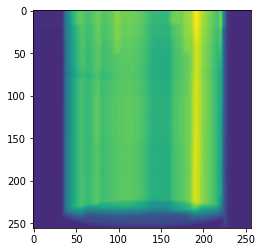

In [92]:
print(tf.shape(inp))
print(tf.shape(inp[tf.newaxis, ...]))
gen_output = generator(inp, training=False)
#gen_output = generator(inp[tf.newaxis, ...], training=False)
# #print(tf.shape(gen_output))
plt.imshow(tf.squeeze(gen_output[0, ...],axis=-1))

### Define the generator loss

GANs learn a loss that adapts to the data, while cGANs learn a structured loss that penalizes a possible structure that differs from the network output and the target image, as described in the [pix2pix paper](https://arxiv.org/abs/1611.07004).

- The generator loss is a sigmoid cross-entropy loss of the generated images and an **array of ones**.
- The pix2pix paper also mentions the L1 loss, which is a MAE (mean absolute error) between the generated image and the target image.
- This allows the generated image to become structurally similar to the target image.
- The formula to calculate the total generator loss is `gan_loss + LAMBDA * l1_loss`, where `LAMBDA = 100`. This value was decided by the authors of the paper.

In [93]:
def generator_loss(gen_output, target):
  # Mean absolute error


  # w = 0.01
  # tar_bkg = tf.where(tf.less_equal(target,0.05),target,0)
  # gen_bkg = tf.where(tf.less_equal(gen_output,0.05),gen_output,0)


  # target_vals = tf.where(tf.greater(target,0.05),target,0)
  # gen_vals = tf.where(tf.greater(gen_output,0.05),gen_output,0)
  # l1_loss = w*tf.reduce_mean(tf.abs(tar_bkg - gen_bkg)) + tf.reduce_mean(tf.abs(target_vals - gen_vals))

  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  return l1_loss

In [94]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.9)

In [95]:
!mkdir -p training_checkpoints
#checkpoint_dir = '/content/drive/MyDrive/Colab Notebooks/3chanGAN_checkpoints'
if not running_local:
    checkpoint_dir = '/content/drive/MyDrive/Colab Notebooks/fold1_checkpoints'
else:
    checkpoint_dir = r'R:\Bojechko\TFRecords\fold1_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 generator=generator)

In [96]:
def plot_images(prediction, input, target):
  plt.figure(figsize=(15, 10))

  # print("Input ")
  # print(type(cbct_input))
  # print(tf.shape(cbct_input))
  # print("ground truth")
  # print(type(tar))
  # print(tf.shape(tar))
  display_list = [ input[0], target[0], prediction[0] ]
  title = ['Input CBCT Image', 'Ground Truth', 'Predicted Image']
  
  plt.subplot(1, 4, 1)
  plt.title('Input Image')
  # Getting the pixel values in the [0, 1] range to plot.
  
  input = tf.squeeze(input,axis=0)
  inslice = input[...,1]
  
  plt.imshow(inslice)
  plt.axis('off')

  plt.subplot(1, 4, 2)
  plt.title('Ground Truth')
  # Getting the pixel values in the [0, 1] range to plot.
  #plt.imshow(tf.squeeze(tar[0],axis=0))
  #tar = tf.cast(tar,tf.float32)
  plt.imshow(tf.squeeze(target[0],axis=-1))
  plt.axis('off')

  plt.subplot(1, 4, 3)
  plt.title('Predicted Image')
  plt.imshow(tf.squeeze(prediction))
  plt.axis('off')

  target = tf.squeeze(target)
  prediction = tf.squeeze(prediction)
  
  predvec = prediction[128,1:256]
  rtvec = target[128,1:256]
  

  plt.axis('off')
  plt.subplot(1, 4, 4)
  plt.plot(rtvec,'g')
  plt.title("Meas RT IMG (Green)")
  plt.plot(predvec,'b')

  # Getting the pixel values in the [0, 1] range to plot.
  #print(tf.shape(prediction))
  #prediction = tf.cast(prediction,tf.float32)
  #plt.imshow(tf.squeeze(prediction[0],axis=-1))
  #plt.axis('off')
  
  plt.show()

In [97]:
!mkdir -p training_checkpoints
checkpoint_dir = '/content/drive/MyDrive/Colab Notebooks/training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 generator=generator)

In [98]:
def generate_images(model, input, tar):
  #prediction = model(input,training=True)
  prediction = model(input,training=False)
  plot_images(prediction, input, tar)

In [99]:
val_iterator = iter(valid_dataset)

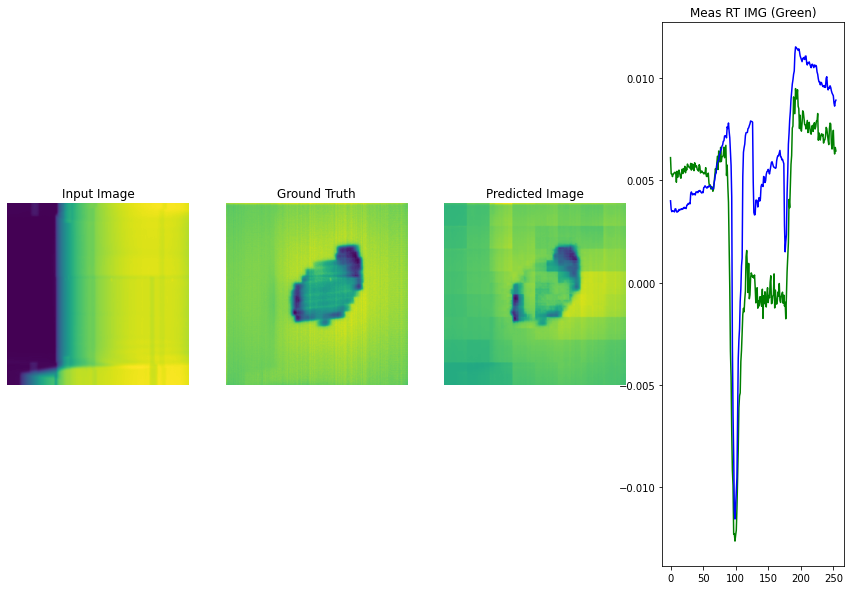

In [117]:
x,y = next(val_iterator)
#pred = model.predict(x)
generate_images(generator, x, y)

In [101]:
log_dir="/content/drive/MyDrive/Colab Notebooks/cboct_logs/"
print(datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

summary_writer = tf.summary.create_file_writer(
  log_dir + "onefrac_cGAN" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

20230121-000314


In [102]:
@tf.function
def train_step(input_image, target, step):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator(input_image, training=True)

    #disc_real_output = discriminator(target, training=True)
    #disc_generated_output = discriminator(gen_output, training=True)

    #disc_real_output = discriminator([input_image,target], training=True)
    #disc_generated_output = discriminator([input_image,gen_output], training=True)

    gen_l1_loss = generator_loss(gen_output, target)
    #disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

  generator_gradients = gen_tape.gradient(gen_l1_loss,
                                          generator.trainable_variables)
  #discriminator_gradients = disc_tape.gradient(disc_loss,
  #                                            discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  #discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
  #                                            discriminator.trainable_variables))
  if (step) % 1000 == 0:
    tf.print(gen_l1_loss)

  with summary_writer.as_default():
    #tf.summary.scalar('gen_total_loss', gen_total_loss, step=step//500)
    #tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=step//500)
    tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=step//500)
    #tf.summary.scalar('disc_loss', disc_loss, step=step//500)

In [103]:
def fit(train_ds, test_ds, steps):
  iterator = iter(test_ds.take(1))
  example = next(iterator)
  ex_input = example[0]
  rtimg = example[1]
  
  #rtimg = tf.squeeze(rtimg, axis=0)
  start = time.time()
  for step, (input_obj) in train_ds.repeat().take(steps).enumerate():
    if (step) % 1000 == 0:
      display.clear_output(wait=True)

      if step != 0:
        print(f'Time taken for 1000 steps: {time.time()-start} sec\n')
        start = time.time()

      generate_images(generator, ex_input, rtimg)
      print(f"Step: {step//1000}k")

    input = input_obj[0]
    target = input_obj[1] 
    train_step(input, target, step)

    # Training step
    if (step+1) % 100 == 0:
      print('.', end='', flush=True)


    # Save (checkpoint) the model every 5k steps
    if (step + 1) % 5000 == 0:
      checkpoint.save(file_prefix=checkpoint_prefix)

Time taken for 1000 steps: 7.802934408187866 sec



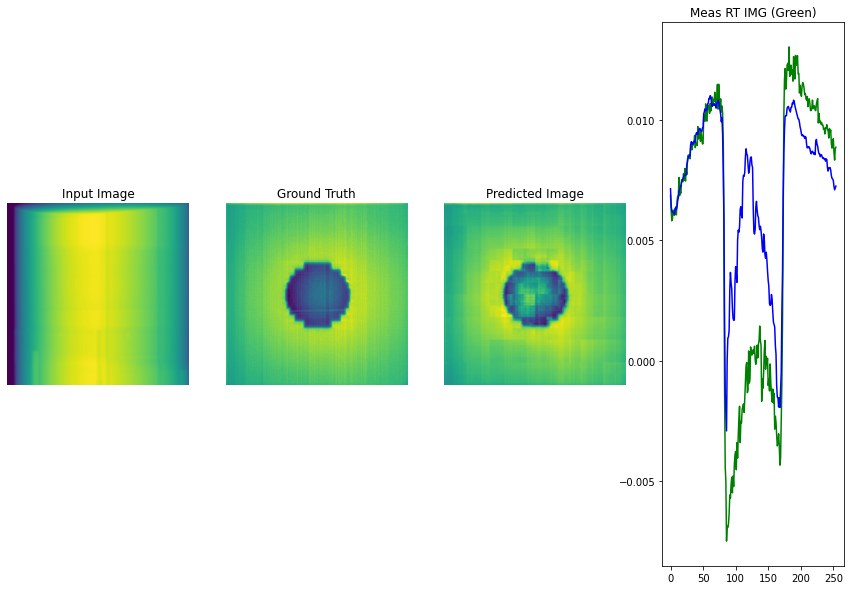

Step: 39k
0.000406620908
..........

In [104]:
fit(train_dataset, valid_dataset, steps=40000)

In [ ]:
mae = tf.keras.metrics.MeanAbsoluteError()
mae_loss = tf.keras.losses.MeanAbsoluteError()
#mae_loss = CustomWeigthed() 

In [ ]:
epochs = 81
train_gen = train_dataset
val_gen = valid_dataset
#train_gen = data_generators['train']
#val_gen = data_generators['validation']
dilation_kernel = 3
scatter = True
add_half = False

for lr in [5.0521e-4]:
  
  #generator = GeneratorE2()
  generator = GeneratorE3(size=4, layers=7, filters_start=4, double_layers=4, add_unet=True, max_filters=64) 
  #generator = GeneratorB(size=4, layers=7, filters_start=4, double_layers=4)
  tensorboard_output = "/content/drive/MyDrive/Colab Notebooks/logs_CB/testphan"
  print(tensorboard_output)
        
  if not os.path.exists(tensorboard_output):
    os.makedirs(tensorboard_output)
  else:
    print("bah")
    #continue
  tensorboard = tf.keras.callbacks.TensorBoard(log_dir=tensorboard_output,
                                                      profile_batch=0,
                                                      write_graph=False)
  generator.compile(optimizer=tf.keras.optimizers.Adam(lr, beta_1=0.5),
                          loss=mae_loss, metrics=[mae])
  print(len(train_gen))
  generator.fit(train_gen, steps_per_epoch=len(train_gen),
                      validation_data=val_gen, epochs=epochs, validation_freq=5,
                      validation_steps=len(val_gen), callbacks=[tensorboard])
  generator.save(os.path.join(tensorboard_output, 'final_model.h5'))

In [ ]:
val_iterator = iter(valid_dataset)
x,y = next(val_iterator)
#pred = model.predict(x)
generate_images(generator, x, y)

In [ ]:
import os
os.listdir('.')

The training procedure for the discriminator is shown below.

To learn more about the architecture and the hyperparameters you can refer to the [pix2pix paper](https://arxiv.org/abs/1611.07004).

## Define the optimizers and a checkpoint-saver


In [ ]:
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 generator=generator)
#Restoring the latest checkpoint in checkpoint_dir
checkpoint_dir = '/content/drive/MyDrive/Colab Notebooks/grad_checkpoints'
print(tf.train.latest_checkpoint(checkpoint_dir))
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

#'/content/drive/MyDrive/Colab Notebooks/phantom_checkpoints/ckpt-8'

## Generate some images using the test set

In [ ]:
#generator.save('/content/drive/MyDrive/Colab Notebooks/3chan_lrgken_L1')

In [30]:
gamma_options = {
    'dose_percent_threshold': 3, 
    'distance_mm_threshold': 3,
    'lower_percent_dose_cutoff': 10,
    'interp_fraction': 20,  # Should be 10 or more, see the paper referenced above
    'max_gamma': 2,
    'random_subset': None,  # Can be used to get quick pass rates
    'local_gamma': False,  # Change to false for global gamma
    'ram_available': 2**29  # 1/2 GB
}

In [31]:
xepidmin = -215.04
xepidmax = 215.04
yepidmin = -215.04
yepidmax = 215.04
grid = 1.68
xepid = np.arange(xepidmin,xepidmax,grid)
yepid = np.arange(yepidmin,yepidmax,grid)
coords = (yepid,xepid)

In [ ]:
# testfiles = tf.io.gfile.glob('/content/drive/My Drive/train/nifti/fold4/12_4_35.*')
# valid_data = load_data(testfiles, tf.estimator.ModeKeys.TRAIN, '/content/drive/My Drive/train/nifti/fold1')

# valid_dataset = tf.data.Dataset.from_tensor_slices((valid_data))
# valid_dataset = valid_dataset.batch(BATCH_SIZE)

In [ ]:
#from importlib import reload

In [ ]:
#pymedphys = reload(pymedphys)
#import pymedphys._utilities

Text(0.5, 1.0, 'Local Gamma (3%/3mm) | Percent Pass: 100.00 %')

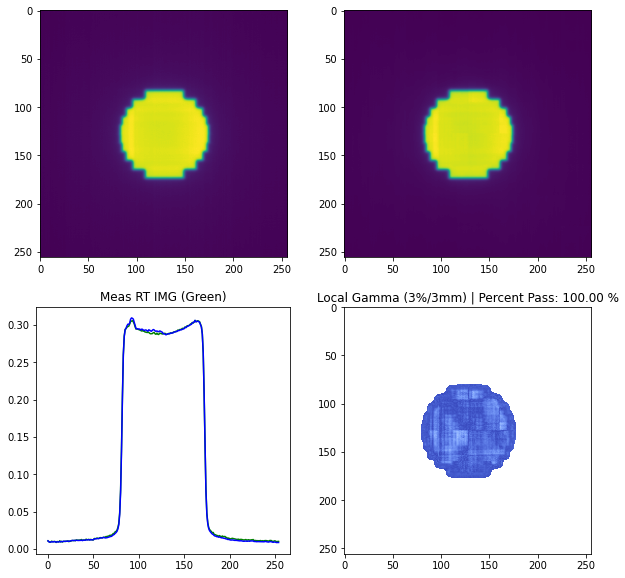

In [285]:
example = next(iter(valid_dataset))
input = example[0]
#print(tf.shape(cbct_input))
tar = example[1]
prediction = generator(input, training=True) 
#prediction = generator.predict(input)

diff = tf.subtract(tar,prediction)
diff = tf.squeeze(diff, axis=0)
diffvec = diff[120,1:256]
tar = tf.squeeze(tar, axis=0)
tar = tf.squeeze(tar, axis=-1)
rtimage = tar

pdos = input[0,...,0].numpy()
cbct = input[0,...,1].numpy()
half = input[0,...,2].numpy()


prediction = tf.squeeze(prediction, axis=0)
prediction = tf.squeeze(prediction, axis=-1)
prediction = prediction


rtimage = pdos*(1.0*np.exp(0.538066**cbct*cbct-2.970*cbct-0.04349)) + rtimage
prediction = pdos*(1.0*np.exp(0.538066**cbct*cbct-2.970*cbct-0.04349)) + prediction


plt.figure(figsize=(10, 10))
  
plt.subplot(2, 2, 1)
plt.imshow(rtimage)
plt.subplot(2, 2, 2)
plt.imshow(prediction)
  
predvec = prediction[128,1:256]
rtvec = rtimage[128,1:256]
  
#predvec = prediction[1:256,128]
#rtvec = rtimage[1:256,128]

plt.subplot(2, 2, 3)
plt.plot(rtvec,'g')
plt.title("Meas RT IMG (Green)")
plt.plot(predvec,'b')
#print(str(example["fname"]))

gamma_test = pymedphys.gamma(coords,rtimage, coords, prediction, **gamma_options)
valid_gamma = gamma_test[~np.isnan(gamma_test)]

num_bins = (
    gamma_options['interp_fraction'] * gamma_options['max_gamma'])
bins = np.linspace(0, gamma_options['max_gamma'], num_bins + 1)

#gamma_no_noise = pymedphys.gamma(coords, rtimage, coords, prediction,**gamma_options)
plt.subplot(2, 2, 4)

plt.imshow( gamma_test, clim=(0, 2), cmap='coolwarm')

# plt.hist(valid_gamma, bins, density=True)
# plt.xlim([0, gamma_options['max_gamma']])
pass_ratio = np.sum(valid_gamma <= 1) / len(valid_gamma)
plt.title(f"Local Gamma ({gamma_options['dose_percent_threshold']}%/{gamma_options['distance_mm_threshold']}mm) | Percent Pass: {pass_ratio*100:.2f} %")

In [ ]:
plt.imshow(gamma_test)

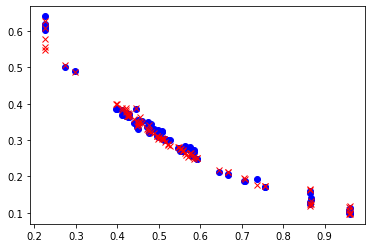

In [221]:
caxcb = [] 
caxrt = []
caxpred = []
caxhalf = []
dataset = valid_dataset

all_ratios = np.zeros(len(list(dataset)))

for example in dataset:
  tinp = example[0]
  ttar = example[1]
  inp = tf.squeeze(tinp,axis=0)
  #slicen = 1
  pdos = tinp[0,...,0].numpy()
  cbct = tinp[0,...,1].numpy()
  half = tinp[0,...,2].numpy()
  cbctcax = np.mean(cbct[126:130,126:130] )
  pdoscax = np.mean(pdos[126:130,126:130] )
  halfcax = np.mean(half[126:130,126:130] )
  #prediction = generator.predict(tinp)
  prediction = generator(tinp, training=True) 
  #ttar = tf.squeeze(ttar, axis=0)
  #ttar = tf.squeeze(ttar, axis=-1)
  rtimage = ttar[0,...,0].numpy()
  

  #out = "cbctcax {} rtcax {}".format(cbctcax,rtcax/pdoscax)
  #print(out)
  prediction = tf.squeeze(prediction, axis=0)
  prediction = tf.squeeze(prediction, axis=-1)

  rtimage = pdos*(1.0*np.exp(0.538066**cbct*cbct-2.970*cbct-0.04349)) + rtimage
  prediction = pdos*(1.0*np.exp(0.538066**cbct*cbct-2.970*cbct-0.04349)) + prediction
  #rtimage = pdos*(1.0*np.exp(-4.0*cbct)+0.15*cbct-0.1*cbct*cbct) + rtimage
  #prediction = pdos*(1.0*np.exp(-4.0*cbct)+0.15*cbct-0.1*cbct*cbct) + prediction

  rtcax = np.mean(rtimage[126:130,126:130])
  predcax = np.mean(prediction[126:130,126:130])
  caxcb = np.append(caxcb,cbctcax)
  caxrt = np.append(caxrt,rtcax/pdoscax)
  caxpred = np.append(caxpred,predcax/pdoscax)
  caxhalf = np.append(caxhalf,halfcax)

#ax = plt.axes(projection='3d')
#ax.scatter3D(caxcb, caxhalf, caxrt, c='b' )
#ax.scatter3D(caxcb, caxhalf, caxpred, c='r' )
#plt.show()


plt.plot(caxcb,caxrt,'bo')
plt.plot(caxcb,caxpred,'rx')

#plt.plot(caxhalf,caxrt,'bo')
#plt.plot(caxhalf,caxpred,'ro')
#plt.ylim([0.8, 1.0])
#plt.xlim([0., 0.1])
plt.show()

In [289]:
dataset = train_dataset
all_ratios = np.zeros(len(list(dataset)))
i = 0
i90 = 0
for example in dataset:
  tinp = example[0]
  ttar = example[1]
  prediction = generator(tinp, training=True)
  #prediction = generator.predict(tinp)
  ttar = tf.squeeze(ttar, axis=0)
  ttar = tf.squeeze(ttar, axis=-1)
  rtimage = ttar

  prediction = tf.squeeze(prediction, axis=0)
  prediction = tf.squeeze(prediction, axis=-1)
  prediction = prediction

  pdos = tinp[0,...,0].numpy()
  cbct = tinp[0,...,1].numpy()
  half = tinp[0,...,2].numpy()


  #rtimage = pdos*(1.0*np.exp(0.538066**cbct*cbct-2.970*cbct-0.04349)) + rtimage
  #prediction = pdos*(1.0*np.exp(0.538066**cbct*cbct-2.970*cbct-0.04349)) + prediction


  gamma_test = pymedphys.gamma(coords,rtimage, coords, prediction, **gamma_options,quiet=True)
  valid_gamma = gamma_test[~np.isnan(gamma_test)]
  pass_ratio = np.sum(valid_gamma <= 1) / len(valid_gamma)
  #tf.print(example["fname"])
  print(pass_ratio)
  print(i)
  all_ratios[i] = pass_ratio
  i = i+1
  if(pass_ratio > 0.90):
    i90 = i90+1

print("mean " + str(np.mean(all_ratios)))
print("STD " + str(np.std(all_ratios))) 
print("max " + str(np.max(all_ratios)))
print("min " + str(np.min(all_ratios)))
print("ratio > 90% " + str(float(i90)/float(i)))
plt.hist(all_ratios)
plt.yscale('log')

<ipython-input-289-492a3eba35e4>:27: DeprecationWarning: Parameter `quiet` will be deprecated in the future
  gamma_test = pymedphys.gamma(coords,rtimage, coords, prediction, **gamma_options,quiet=True)


0.7517055289685368
0


KeyboardInterrupt: ignored

In [ ]:
example = next(iter(train_dataset))
x = example[0]
y = example[1]
#x, y = next(iterx)
#print(train_len)
#print(valid_len)
#print(test_len)
#plt.imshow(y[0,...,0])
prediction = generator.predict(x)
prediction = tf.squeeze(prediction, axis=0)
prediction = tf.squeeze(prediction, axis=-1)
rt = y[0,...,0].numpy()

pdos = x[0,...,0].numpy()
cbct = x[0,...,1].numpy()

plt.figure(figsize=(10, 10))
plt.subplot(1,3,1)

plt.imshow(rt)
#plt.plot(pdos[128,1:256],'b')
#plt.plot(cbct[128,1:256],'r')

#plt.show()

cbctval = []
ratio = []
pdosval = [] 
pred = []

rtmax = rt.max(0).max(-1)
#print(rtmax)

for i in range(0,256):
  for j in range(0,256):
    if(rt[i,j] > rtmax*0.5):
      cbctval = np.append(cbctval,cbct[i,j])
      pdosval = np.append(pdosval,pdos[i,j])
      ratio = np.append(ratio,rt[i,j]/pdos[i,j])
      pred = np.append(pred,prediction[i,j]/pdos[i,j])

plt.subplot(1,3,2)
plt.plot(cbctval,ratio,'bo')
plt.plot(cbctval,pred,'ro')
#xp = np.arange(0, 200.0, 0.1)
#yp = np.exp(-4.0/255 * xp) + 0.15/255 * xp - 0.1/65025 * xp * xp
# #yp = pdosval*( np.exp(-4.0/255 *cbctval) + 0.15/255 * cbctval - 0.1/65025 * cbctval * cbctval)
xp = np.arange(0, 1.0, 0.01)
#yp = np.exp(-4.0 * xp) + 0.15 * xp -0.1* xp * xp
yp = np.exp(0.7885*xp*xp-3.523*xp-0.04555)
#yp = np.exp(-4.0 * xp) -0.1* xp * xp

plt.plot(xp, yp,'r')

#plt.subplot(1,3,3)
#plt.plot(rt[128,1:256]/pdos[128,1:256],'b')
#plt.plot(pdos[128,1:256],'r')
#plt.plot(rt[128,1:256],'b')

In [ ]:
generator.summary()